# This explores using a 1 sec moving window Hilbert transform to extract the magnitude of bandpassed iEEG data

A Butterworth filter is used for bandpass filtering the data before applying the Hilbert transform.

In [3]:
import numpy as np
import pandas as pd
import scipy.io
import os
import ieeg_funcs as ief
import dgFuncs as dg
from sklearn import preprocessing
import sys
from scipy import stats
import scipy.io as sio
from scipy import signal
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
# Reimport functions
import imp
imp.reload(ief)

<module 'ieeg_funcs' from '/Users/davidgroppe/PycharmProjects/DG_LIBRARY/ieeg_funcs.py'>

In [12]:
# Define frequency bands
freq_bands=[(0, 4), (4, 8), (8, 13), (13,30), (30,50), (70, 100)]
band_labels=['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma', 'High Gamma']
n_band=len(freq_bands)
print('# of freq bands %d' % n_band)

# of freq bands 6


In [14]:
# Load an example data set
#in_fname='/home/dgroppe/TWH_EEG/NA/EEG_MAT/NA_d1_sz2.mat'
in_fname='/Users/davidgroppe/ONGOING/TWH_EEG_ORIG/NA/NA_d1_sz2.mat'
mat_dat=sio.loadmat(in_fname)
Sf=mat_dat['Sf']
#mat_dat.keys()

if Sf==500:
    # Downsample to 250 Hz
    print('Downsampling data to 250 Hz')
    vltg_dat=signal.decimate(mat_dat['matrix_bi'],2,axis=0,zero_phase=True)
    Sf=250
elif Sf==250:
    vltg_dat=mat_dat['matrix_bi']
else:
    raise ValueError('Sf needs to be 500 or 250')

# Get SOZ chan
# soz_id=0 # TODO ?? get actual chan
# n_tpt, n_chan=mat_dat['matrix_bi'].shape
n_tpt, n_chan=vltg_dat.shape
data_time_sec=np.arange(0,n_tpt)/Sf

# Detrend data. Some patients have a crazy trend in the first channel
dat=signal.detrend(vltg_dat,0)
# plt.figure(1)
# plt.clf()
# plt.plot(mat_dat['matrix_bi'][:,0],'b-')
# plt.plot(dat[:,0],'r--')

bp_data=np.zeros((n_band,n_chan,n_tpt))
filt_order=4
# Bandpass filter the data
for band_ct, band in enumerate(freq_bands):
    print('Working on {} Hz'.format(band))
    bp_data[band_ct,:,:]=ief.causal_butter(dat.T,Sf,band,filt_order)
    
# plt.figure(2)
# plt.clf()
# plt.plot(dat[:,0],'r-')
# plt.plot(bp_data[0,0,:],'g--')
# plt.plot(bp_data[3,0,:],'m--')

Downsampling data to 250 Hz
Working on (0, 4) Hz
Working on (4, 8) Hz
Working on (8, 13) Hz
Working on (13, 30) Hz
Working on (30, 50) Hz
Working on (70, 100) Hz


In [16]:
# Apply 1 second moving window hilbert transform and magnitude at SOZ chan
# Just doing SOZ channel for the time being TODO do all channels
n_half_wind=int(np.round(Sf/2))
wind_step=int(np.round(Sf/10))
n_hilby_tpt=len(np.arange(n_half_wind,n_tpt-n_half_wind,wind_step))
hilby_mag=np.zeros((n_band,n_hilby_tpt))
hilby_sec=np.zeros(n_hilby_tpt)
hilby_ct=0
soz_id=12
#for tpt_ct in range(n_half_wind,n_tpt-n_half_wind-1): #TODO use this
for tpt_ct in range(n_half_wind,n_tpt-n_half_wind,wind_step):
    hilby=signal.hilbert(bp_data[:,soz_id,(tpt_ct-n_half_wind):(tpt_ct+n_half_wind)])
    #temp=data_time_sec[0,(tpt_ct-n_half_wind):(tpt_ct+n_half_wind+1)] # just to double check indexing
    hilby_mag[:,hilby_ct]=np.mean(np.abs(hilby),axis=1) # grab value of middle time point
    hilby_sec[hilby_ct]=np.mean(data_time_sec[(tpt_ct-n_half_wind):(tpt_ct+n_half_wind+1)])
    hilby_ct+=1
    #print('%f vs. %f' % (data_time_sec[0,tpt_ct],hilby_time_sec[tpt_ct]))
print('done!')

done!


In [17]:
# Import Channel Info
in_fname='/Users/davidgroppe/ONGOING/TWH_EEG/NA/NA_channel_info.csv'
chan_df=pd.read_csv(in_fname,names=['Channel'])
for chan_ct, chan in enumerate(chan_df['Channel']):
    print('%d: %s' % (chan_ct,chan))
#pd.read_csv?

0: LHD1-LHD2
1: LHD2-LHD3
2: LHD3-LHD4
3: LAT1-LAT2
4: LAT2-LAT3
5: LAT3-LAT4
6: LMT1-LMT2
7: LMT2-LMT3
8: LMT3-LMT4
9: LPT1-LPT2
10: LPT2-LPT3
11: LPT3-LPT4
12: RHD1-RHD2
13: RHD2-RHD3
14: RHD3-RHD4
15: RAT1-RAT2
16: RAT2-RAT3
17: RAT3-RAT4
18: RMT1-RMT2
19: RMT2-RMT3
20: RMT3-RMT4
21: RSPT1-RSPT2
22: RSPT2-RSPT3
23: RSPT3-RSPT4
24: RSPT4-RSPT5
25: RSPT5-RSPT6
26: RIPT1-RIPT2
27: RIPT2-RIPT3
28: RIPT3-RIPT4
29: RIPT4-RIPT5
30: RIPT5-RIPT6


In [18]:
# Extract power magnitude from hilbert transform
soz_id=12
bp_mag=np.abs(hilby_data[:,soz_id,:])

NameError: name 'hilby_data' is not defined

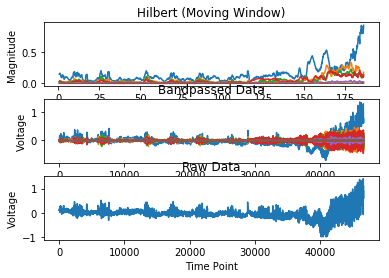

In [24]:
plt.figure(3)
plt.clf()
plt.subplot(3,1,1)
for band_ct in range(n_band):
    plt.plot(hilby_sec,hilby_mag[band_ct,:].T,label=band_labels[band_ct]);
#plt.legend()
plt.title('Hilbert (Moving Window)')
plt.ylabel('Magnitude')

plt.subplot(3,1,2)
for band_ct in range(n_band):
    plt.plot(bp_data[band_ct,soz_id,:].T,label=band_labels[band_ct]);
#plt.legend()
plt.title('Bandpassed Data')
plt.ylabel('Voltage')

plt.subplot(3,1,3)
plt.plot(dat[:,soz_id])
plt.title('Raw Data')
plt.xlabel('Time Point')
plt.ylabel('Voltage')

# plt.savefig('hilbert_mag_moving.png')

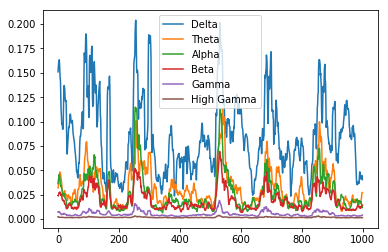

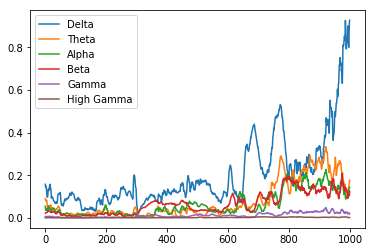

In [28]:
# Plot beginning and ending time points
plt.figure(1)
plt.clf()
for band_ct in range(n_band):
    plt.plot(hilby_mag[band_ct,0:1000].T,label=band_labels[band_ct]);
plt.legend()

plt.figure(2)
plt.clf()
for band_ct in range(n_band):
    plt.plot(hilby_mag[band_ct,-1000:].T,label=band_labels[band_ct]);
plt.legend()

In [29]:
# trimmed z-score features as was done with previous DFT code
hilby_mag_z=hilby_mag.copy()
#bp_mag_z=np.log(bp_mag.copy()**2)
# print(bp_mag[0,0])
# print(bp_mag_z[0,0])
dg.trimmed_normalize(hilby_mag_z,0.4);

6 dimensions
1860 observations


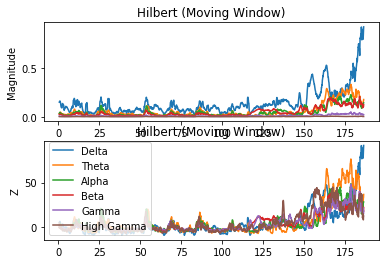

In [31]:
plt.figure(4)
plt.clf()
plt.subplot(2,1,1)
for band_ct in range(n_band):
    plt.plot(hilby_sec,hilby_mag[band_ct,:].T,label=band_labels[band_ct]);
#plt.legend()
plt.title('Hilbert (Moving Window)')
plt.ylabel('Magnitude')

plt.subplot(2,1,2)
for band_ct in range(n_band):
    plt.plot(hilby_sec,hilby_mag_z[band_ct,:].T,label=band_labels[band_ct]);
plt.legend()
plt.title('Hilbert (Moving Window)')
plt.ylabel('Z')

In [ ]:
# Plot spectrogram along with hilbert features to verify accuracy

In [32]:
# Load DFT based features and compare with Hilbert based Features
in_fname='/Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/PWR/NA/NA_d1_sz2_bppwr.npz'
dft=np.load(in_fname)
print(dft.keys())

# n_dft_tpt=len(dft['time_wind_sec'])
# resamp_bp_mag_z=np.zeros((n_band,n_dft_tpt))
# for a in range(n_dft_tpt):
#     match_id=dg.find_nearest(hilby_time_sec,dft['time_wind_sec'][a])
#     resamp_bp_mag_z[:,a]=np.mean(bp_mag_z[:,match_id-125:match_id+125],axis=1)

['peri_ictal', 'time_wind_sec', 'ftrs', 'ftr_list']


In [34]:
dft['ftrs'].shape

(6, 1860)

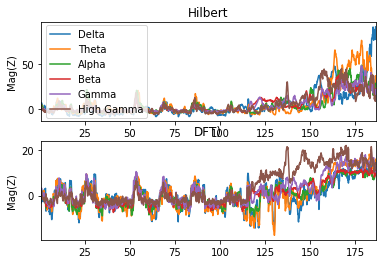

In [40]:
min_sec=np.min([np.min(hilby_sec), np.min(dft['time_wind_sec'])])
max_sec=np.max([np.max(hilby_sec), np.max(dft['time_wind_sec'])])
plt.figure(5)
plt.clf()
plt.subplot(2,1,1)
for band_ct in range(n_band):
    plt.plot(hilby_sec,hilby_mag_z[band_ct,:].T,label=band_labels[band_ct]);
plt.xlim([min_sec, max_sec])
plt.legend(loc='center left')
plt.title('Hilbert')
plt.ylabel('Mag(Z)')

plt.subplot(2,1,2)
for band_ct in range(n_band):
    plt.plot(dft['time_wind_sec'],dft['ftrs'][band_ct,:].T,label=band_labels[band_ct]);
plt.xlim([min_sec, max_sec])
#plt.legend()
plt.title('DFT)')
plt.ylabel('Mag(Z)');

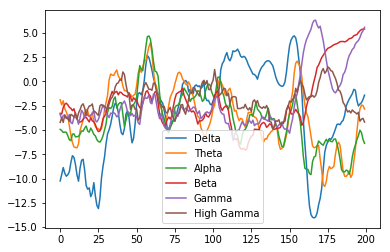

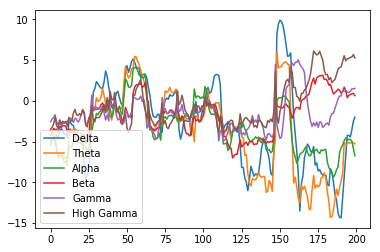

In [114]:
plt.figure(3)
plt.clf()
for band_ct in range(n_band):
    plt.plot(resamp_bp_mag_z[band_ct,1000:1200].T,label=band_labels[band_ct]);
plt.legend()

plt.figure(4)
plt.clf()
for band_ct in range(n_band):
    plt.plot(dft['ftrs'][band_ct,1000:1200].T,label=band_labels[band_ct]);
plt.legend()

1860


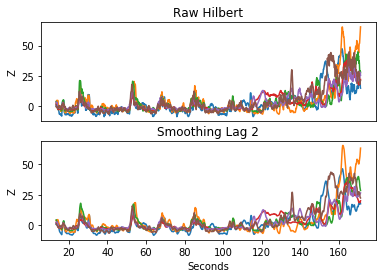

In [11]:
# Load Hilbert-processed results from one of my scripts
npz_fname='/Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/MAG/NA/NA_d1_sz2_bpmag.npz'
npz_dict=np.load(npz_fname)
npz_dict.keys()

#Load Hilbert-processed AND SMOOTHED results from one of my scripts
npz_fname1='/Users/davidgroppe/PycharmProjects/SZR_ANT/FTRS/MAG_LAG2/NA/NA_d1_sz2_bpmag_lag2.npz'
npz_dict1=np.load(npz_fname1)
npz_dict1.keys()
print(len(npz_dict['time_wind_sec']))

# Plot raw Hilbert and Smoothed for comparison
mid_tpt=int(np.round(len(npz_dict['time_wind_sec'])/2))
dlt=800
plt.figure(11)
plt.clf()
plt.subplot(2,1,1)
plt.plot(npz_dict['time_wind_sec'][mid_tpt-dlt:mid_tpt+dlt],
         npz_dict['ftrs'][:,mid_tpt-dlt:mid_tpt+dlt].T);
plt.ylabel('Z')
plt.xticks([])
plt.title('Raw Hilbert')

plt.subplot(2,1,2)
plt.plot(npz_dict1['time_wind_sec'][mid_tpt-dlt:mid_tpt+dlt],
         npz_dict1['ftrs'][:,mid_tpt-dlt:mid_tpt+dlt].T);
plt.ylabel('Z')
plt.title('Smoothing Lag 2')
plt.xlabel('Seconds');

6 dimensions
1860 observations
Saving fig to file smooth_fact1.png
6 dimensions
1860 observations
Saving fig to file smooth_fact2.png
6 dimensions
1860 observations
Saving fig to file smooth_fact3.png
6 dimensions
1860 observations
Saving fig to file smooth_fact4.png
6 dimensions
1860 observations
Saving fig to file smooth_fact5.png
6 dimensions
1860 observations
Saving fig to file smooth_fact6.png
6 dimensions
1860 observations
Saving fig to file smooth_fact7.png
6 dimensions
1860 observations
Saving fig to file smooth_fact8.png
6 dimensions
1860 observations
Saving fig to file smooth_fact9.png
6 dimensions
1860 observations
Saving fig to file smooth_fact10.png


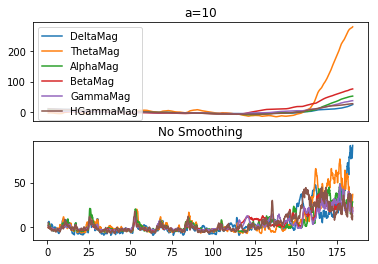

In [140]:
# Compute, plot, and save to disk the results of various values of smoothing parameter a. 
# Bigger values mean more smoothing
for a in range(1,11):
    lag_act=np.copy(npz_dict['ftrs'])
    alph=1/(2**a)
    for t in range(1,lag_act.shape[1]):
        lag_act[:,t]=alph*lag_act[:,t]+(1-alph)*lag_act[:,t-1]
    dg.trimmed_normalize(lag_act,0.4)

    plt.figure(11)
    plt.clf()
    plt.subplot(2,1,1)
    for b_ct, band in enumerate(npz_dict['ftr_list']):
        plt.plot(npz_dict['time_wind_sec'],lag_act[b_ct,:].T,label=band);
    plt.legend(loc='upper left')
    plt.title('a='+str(a))
    plt.xticks([])

    plt.subplot(2,1,2)
    plt.plot(npz_dict['time_wind_sec'],npz_dict['ftrs'].T)
    plt.title('No Smoothing')

    out_fname='smooth_fact'+str(a)+'.png'
    print('Saving fig to file %s' % out_fname)
    plt.savefig(out_fname)